# Optuna によるハイパーパラメタ最適化。
Optunaが分かる76枚のスライド⇒https://www.slideshare.net/pfi/pydatatokyo-meetup-21-optuna
#XGBoostでやってみる。

Optunaのドキュメント⇒https://optuna.readthedocs.io/en/stable/index.html

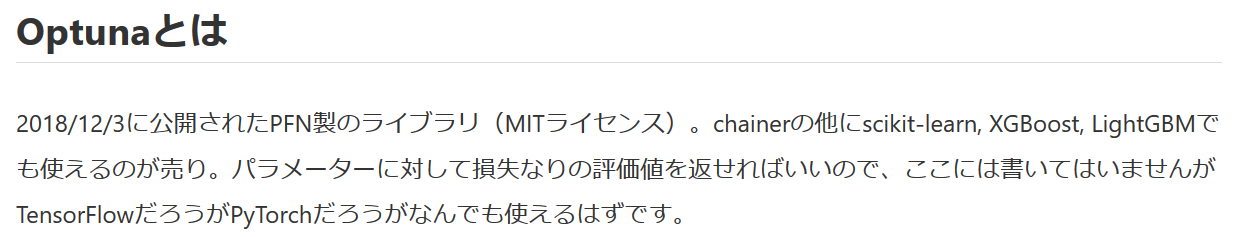

## ★データの取得＆前処理
このデータを使います。http://opendata-catalogue.metro.tokyo.jp/dataset/t000022d0000000034/resource/d3ff163d-d89d-4da8-b5a6-6c0bb3911146

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#東京で発生したひったくりのデータをブースティングする！
HTKR = pd.read_csv('tokyo_2018_HTKR.csv',encoding='CP932')

In [3]:
#説明変数
X_HTKR   = HTKR.iloc[:,1:5] 
##解析用にデータ編集（全部int型にする必要があるらしい。カテゴリカル⇒数値データ）
X_HTKR["被害者の年齢"]   = X_HTKR["被害者の年齢"].astype(int)
X_HTKR["発生場所の属性"] = X_HTKR["発生場所の属性"].map( {'道路上':0,'その他':1} ).astype(int)
X_HTKR["被害者の性別"]   = X_HTKR["被害者の性別"].map( {'男性':0,'女性':1} ).astype(int)
#X_HTKR['aaaa'] = X_HTKR['aaaa'].fillna(X_HTKR['aaaa'].mean()) #←欠損値補正も出来る。

#目的変数
Y_HTKR   = HTKR.iloc[:,5]
#０＝ひったくり失敗。１＝ひったくり成功。
Y_HTKR   = Y_HTKR.map( {'なし':0,'あり':1} ).astype(int)

In [4]:
#カテゴリカル変数をラベルエンコーディングしたのでも学習可能！
#名義尺度も、適当な数値で分ける！
X_HTKR[:2]

,発生時（始期）,発生場所の属性,被害者の性別,被害者の年齢
0,21,0,1,30
1,21,0,1,50


In [5]:
#カテゴリカル変数をラベルエンコーディングしたのでも学習可能！
#名義尺度も、適当な数値で分ける！
Y_HTKR[:2]

0    1
1    1
Name: 現金被害の有無, dtype: int32

In [6]:
X_HTKR.dtypes
Y_HTKR.dtypes

dtype('int32')

In [7]:
# 学習データとテストデータを分ける
# stratify = yを入れると、均等にデータを分けてくれる。データに偏りがなくなる。
X_train, X_test, y_train, y_test = train_test_split(X_HTKR, Y_HTKR, test_size = 0.2, random_state = 42, stratify = Y_HTKR)

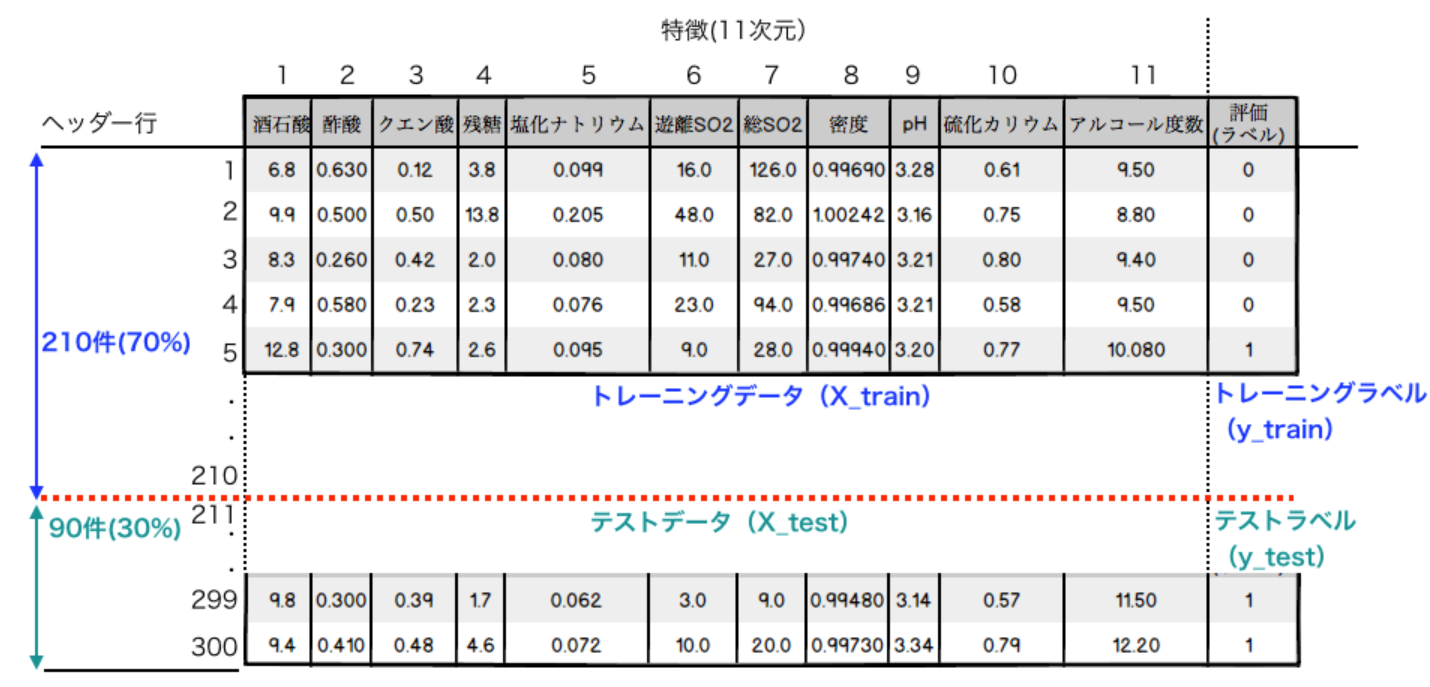
説明⇒https://note.nkmk.me/python-sklearn-train-test-split/

## ★XGBoostのハイパーパラメータ調整をOptunaでやる。
ドキュメント⇒https://xgboost.readthedocs.io/en/latest/parameter.html　分かり易い⇒http://kamonohashiperry.com/archives/209

例１⇒https://qiita.com/kuroneko-hornet/items/9e3e8ffba75c1dbf11c6　例２⇒https://qiita.com/yshi12/items/4178f54da8c162ea55f3

In [8]:
# XGBOOST用のライブラリ読み込み
#>>pip install xgboost
import xgboost as xgb

In [9]:
#XGBoostでモデル構築
def train(xxx,yyy,max_depth,learning_rate,num_round):
    dtrain = xgb.DMatrix(xxx,label=yyy)
    param = { 'max_depth':max_depth,'learning_rate':learning_rate,'objective':'binary:logistic' }
    bst = xgb.train(param,dtrain,num_round)
    return bst

In [10]:
#構築したモデルで予測する
def predict(bst,df):
    #                           　↓テスト用データ（説明変数のみ入れることで、構築済みモデルを使って予測結果を出力する！）
    return bst.predict(xgb.DMatrix(df))

In [11]:
#パラメタ設定
max_depth = 3
learning_rate = 0.6
round_num = 5

In [12]:
#XGBoostの実行！
bst = train(X_train,y_train,max_depth,learning_rate,round_num)

C:\Users\araik\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [13]:
#テストしてみる。(VSトレインデータ)
answer = predict(bst,X_train).round().astype(int)
print('train score :',accuracy_score(answer.round(),y_train))

train score : 0.8516746411483254


In [14]:
#テストしてみる。(VSテストデータ)
answer = predict(bst,X_test).round().astype(int)
xgb.plot_importance(bst)
print('test score :',accuracy_score(answer.round(),y_test))

test score : 0.8301886792452831


#### 構築したモデルの結果を確認する。

In [15]:
#目的変数に対して、最も寄与度の高った変数を出力する。
bst.get_score(importance_type='total_gain')

{'発生時（始期）': 22.295855518,
 '発生場所の属性': 0.546974182,
 '被害者の年齢': 8.299750501000002,
 '被害者の性別': 0.0140016079}

In [16]:
#作った木を見れる。　　　　↓０＝＞１回目の木
xgb.to_graphviz(bst, num_trees=0)
##２回目以降の木は、差分を埋める木なので、見なくてもいいかも。。

ImportError: You must install graphviz to plot tree

## Optunaでパラメタ最適化します！
Optunaの使い方⇒https://qiita.com/ryota717/items/28e2167ea69bee7e250d

In [124]:
import optuna
from functools import partial

In [118]:
#目的関数「＝損失関数」(このリターンを最小にするようにパラメタ調整する。)
##trialオブジェクトを使用して定義する！                 ↓必須！
def objective(xxx_train,yyy_train, xxx_test,yyy_test, trial):
   #----変数テーブル-------------------------------------------------------------
    max_depth = trial.suggest_int('max_depth',1,30)
    learning_rate = trial.suggest_uniform('learning_rate',0.0,1)
    round_num = trial.suggest_int('round_num',1,30) 
   #----------------------------------------------------------------------------- 
   #int = 整数。 uniform=連続量。
    
    bst = train(xxx_train,yyy_train, max_depth,learning_rate,round_num)

    answer = predict(bst,xxx_test).round().astype(int)
    score = accuracy_score(answer.round(),yyy_test)
    
    #↓テストデータを使った誤差。
    return 1.0 - score

In [119]:
#optunaの前処理
#               ↓ロス関数 ↓トレインデータ＆テストデータ。           
obj_f = partial(objective, X_train, y_train, X_test, y_test)

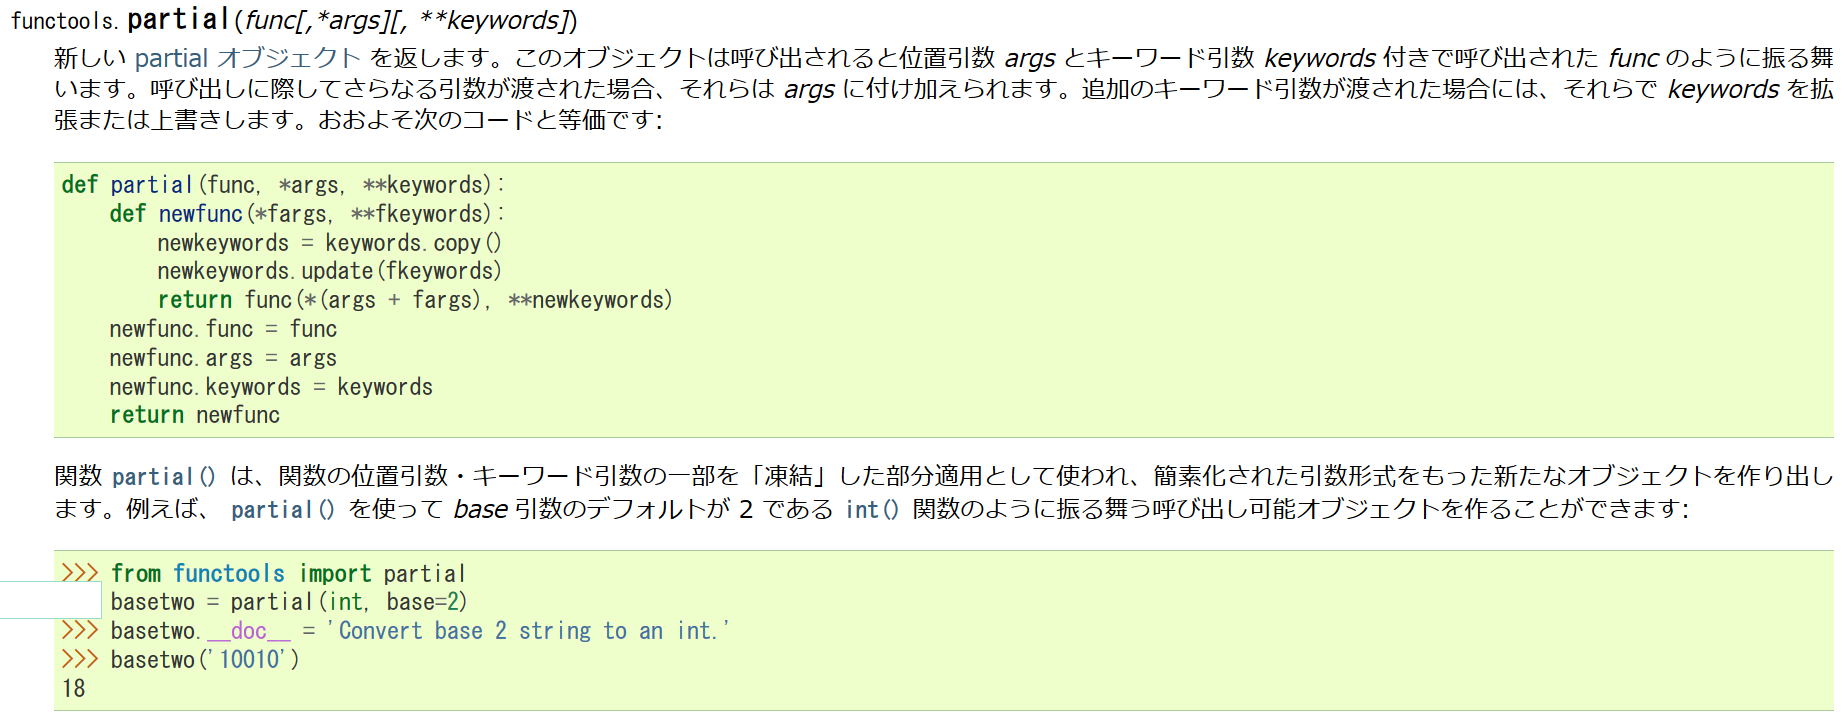

In [120]:
#セッション作成
study = optuna.create_study()

In [122]:
#回数
study.optimize(obj_f, n_trials=100)

[I 2019-10-24 18:53:06,628] Finished a trial resulted in value: 0.2075471698113207. Current best value is 0.2075471698113207 with parameters: {'max_depth': 30, 'learning_rate': 0.6750434650095417, 'round_num': 2}.
[I 2019-10-24 18:53:06,648] Finished a trial resulted in value: 0.18867924528301883. Current best value is 0.18867924528301883 with parameters: {'max_depth': 19, 'learning_rate': 0.3694801823986853, 'round_num': 7}.
[I 2019-10-24 18:53:06,662] Finished a trial resulted in value: 0.2075471698113207. Current best value is 0.18867924528301883 with parameters: {'max_depth': 19, 'learning_rate': 0.3694801823986853, 'round_num': 7}.
[I 2019-10-24 18:53:06,692] Finished a trial resulted in value: 0.24528301886792447. Current best value is 0.18867924528301883 with parameters: {'max_depth': 19, 'learning_rate': 0.3694801823986853, 'round_num': 7}.
[I 2019-10-24 18:53:06,718] Finished a trial resulted in value: 0.2075471698113207. Current best value is 0.18867924528301883 with paramete

[I 2019-10-24 18:53:11,484] Finished a trial resulted in value: 0.18867924528301883. Current best value is 0.15094339622641506 with parameters: {'max_depth': 2, 'learning_rate': 0.9089284024552422, 'round_num': 7}.
[I 2019-10-24 18:53:11,573] Finished a trial resulted in value: 0.18867924528301883. Current best value is 0.15094339622641506 with parameters: {'max_depth': 2, 'learning_rate': 0.9089284024552422, 'round_num': 7}.
[I 2019-10-24 18:53:11,674] Finished a trial resulted in value: 0.26415094339622647. Current best value is 0.15094339622641506 with parameters: {'max_depth': 2, 'learning_rate': 0.9089284024552422, 'round_num': 7}.
[I 2019-10-24 18:53:11,767] Finished a trial resulted in value: 0.2075471698113207. Current best value is 0.15094339622641506 with parameters: {'max_depth': 2, 'learning_rate': 0.9089284024552422, 'round_num': 7}.
[I 2019-10-24 18:53:11,866] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameter

In [123]:
#最適パラメータを使って、もう一度XGBoost
max_depth = study.best_params['max_depth']
learning_rate = study.best_params['learning_rate']
round_num = study.best_params['round_num']

bst = train(X_train,y_train,max_depth,learning_rate,round_num)

print('\nparams :',study.best_params)
answer = predict(bst,X_train).round().astype(int)
print('train score :',accuracy_score(answer.round(),y_train))
answer = predict(bst,X_test).round().astype(int)
xgb.plot_importance(bst)
print('test score :',accuracy_score(answer.round(),y_test))


params : {'max_depth': 2, 'learning_rate': 0.9089284024552422, 'round_num': 7}
train score : 0.8564593301435407
test score : 0.8490566037735849


↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑適当に指定した時よりも、少し精度が向上しました！

Optunaを使った一連の流れ⇒「ロス関数（opt）の定義⇒スタディオブジェクト作成⇒スタディオブジェクトにロス関数とデータを入れる。⇒最適化パラメータの発見。」

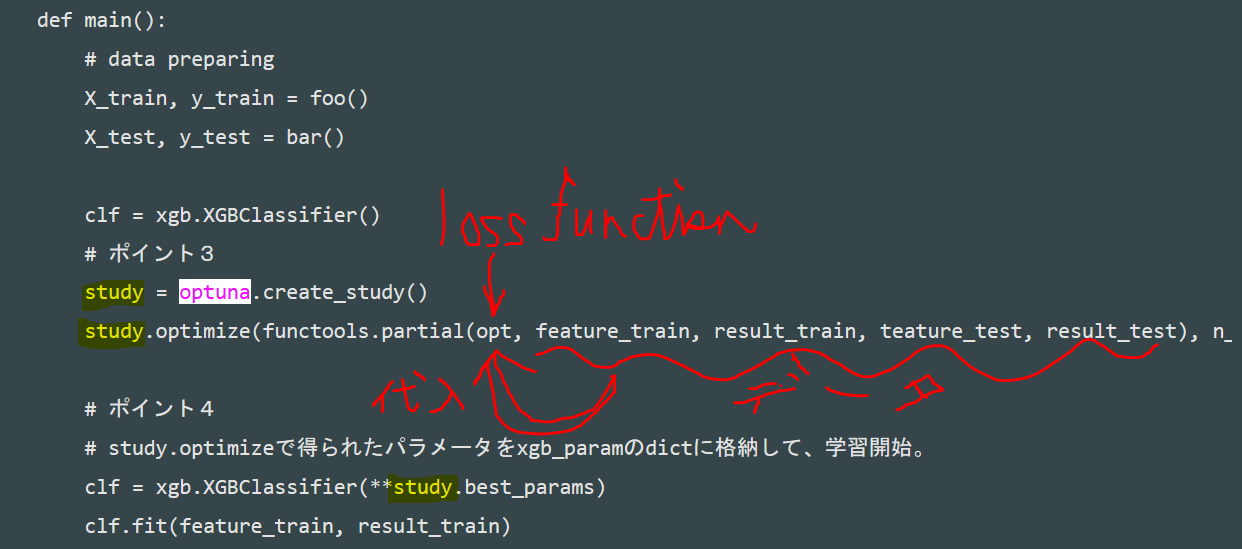

## Optunaで、パラメータを指定しまくる。（時間かかる。）

In [130]:
#XGBoostでモデル構築
def train_mul(xxx,yyy,max_depth,learning_rate,objective,gamma,subsample,colsample_bytree,min_childe_weigh,alpha,num_round):
    dtrain = xgb.DMatrix(xxx,label=yyy)
    param = { 'max_depth':max_depth,
              'learning_rate':learning_rate,
              'objective':objective,
              'gamma':gamma,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree,
              'min_childe_weigh':min_childe_weigh,
              'alpha':alpha            
            }
    bst = xgb.train(param,dtrain,num_round)
    return bst

引数を要確認。ドキュメント(パラメタ編)⇒https://xgboost.readthedocs.io/en/latest/parameter.html

In [132]:
#目的関数「＝損失関数」(このリターンを最小にするようにパラメタ調整する。)
##trialオブジェクトを使用して定義する！                 ↓必須！
def objective_mul(xxx_train,yyy_train, xxx_test,yyy_test, trial):
   #----変数テーブル-------------------------------------------------------------
    max_depth = trial.suggest_int('max_depth',1,30)
    learning_rate = trial.suggest_uniform('learning_rate',0.0,1)
    objective = trial.suggest_categorical('objective',['binary:logistic','binary:logitraw','binary:hinge'])
    gamma = trial.suggest_uniform('gamma',0.0,1)    
    subsample = trial.suggest_uniform('subsample',0.0,1)
    colsample_bytree = trial.suggest_uniform('colsample_bytree',0.0,1)
    min_childe_weigh = trial.suggest_uniform('min_childe_weigh',0.0,1)    
    alpha = trial.suggest_uniform('alpha',0.0,1)        
    round_num = trial.suggest_int('round_num',1,30) 
   #----------------------------------------------------------------------------- 
   #int = 整数。 uniform=連続量。
    
    bst = train_mul(xxx_train,yyy_train, 
                max_depth,learning_rate, objective, gamma, subsample, colsample_bytree, min_childe_weigh,alpha,round_num)

    answer = predict(bst,xxx_test).round().astype(int)
    score = accuracy_score(answer.round(),yyy_test)
    
    #↓テストデータを使った誤差。
    return 1.0 - score

In [137]:
#optunaの前処理
#                       ↓ロス関数 ↓トレインデータ＆テストデータ。           
obj_f_mul = partial(objective_mul, X_train, y_train, X_test, y_test)
#セッション作成
study_mul = optuna.create_study()
#回数
study_mul.optimize(obj_f_mul, n_trials=300)

[I 2019-10-24 21:26:18,398] Finished a trial resulted in value: 0.2075471698113207. Current best value is 0.2075471698113207 with parameters: {'max_depth': 12, 'learning_rate': 0.6299662284881656, 'objective': 'binary:logistic', 'gamma': 0.33627442008119424, 'subsample': 0.20187837853537038, 'colsample_bytree': 0.7442559955434196, 'min_childe_weigh': 0.9816787159255428, 'alpha': 0.6460300705416114, 'round_num': 10}.
[I 2019-10-24 21:26:18,445] Finished a trial resulted in value: 0.2075471698113207. Current best value is 0.2075471698113207 with parameters: {'max_depth': 12, 'learning_rate': 0.6299662284881656, 'objective': 'binary:logistic', 'gamma': 0.33627442008119424, 'subsample': 0.20187837853537038, 'colsample_bytree': 0.7442559955434196, 'min_childe_weigh': 0.9816787159255428, 'alpha': 0.6460300705416114, 'round_num': 10}.
[I 2019-10-24 21:26:18,461] Finished a trial resulted in value: 0.18867924528301883. Current best value is 0.18867924528301883 with parameters: {'max_depth': 14

[I 2019-10-24 21:26:21,260] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:21,369] Finished a trial resulted in value: 0.2264150943396226. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:21,481] Finished a trial resulted in value: 0.2264150943396226. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9,

[I 2019-10-24 21:26:25,942] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:26,073] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:26,214] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameters: {'max_depth': 

[I 2019-10-24 21:26:31,752] Finished a trial resulted in value: 0.18867924528301883. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:31,937] Finished a trial resulted in value: 0.15094339622641506. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:32,107] Finished a trial resulted in value: 0.18867924528301883. Current best value is 0.15094339622641506 with parameters: {'max_depth': 

[I 2019-10-24 21:26:39,169] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:39,372] Finished a trial resulted in value: 0.15094339622641506. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:39,557] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameters: {'max_depth': 

[I 2019-10-24 21:26:47,460] Finished a trial resulted in value: 0.18867924528301883. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:47,691] Finished a trial resulted in value: 0.2264150943396226. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:47,912] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9

[I 2019-10-24 21:26:56,879] Finished a trial resulted in value: 0.2264150943396226. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:57,142] Finished a trial resulted in value: 0.679245283018868. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:26:57,395] Finished a trial resulted in value: 0.18867924528301883. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 

[I 2019-10-24 21:27:07,209] Finished a trial resulted in value: 0.2075471698113207. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:27:07,499] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}.
[I 2019-10-24 21:27:07,811] Finished a trial resulted in value: 0.16981132075471694. Current best value is 0.15094339622641506 with parameters: {'max_depth': 9


params : {'max_depth': 9, 'learning_rate': 0.8411387572038852, 'objective': 'binary:logistic', 'gamma': 0.9272332660003565, 'subsample': 0.9645352764086641, 'colsample_bytree': 0.23450212078199506, 'min_childe_weigh': 0.8408725609561294, 'alpha': 0.13045587750617804, 'round_num': 27}
train score : 0.8229665071770335
test score : 0.8490566037735849


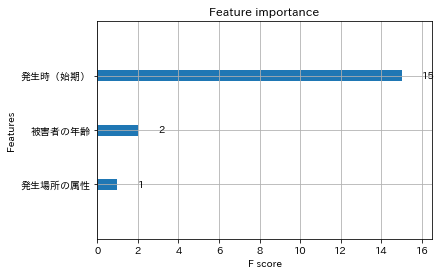

In [139]:
#最適パラメータを使って、もう一度XGBoost
max_depth = study_mul.best_params['max_depth']
learning_rate = study_mul.best_params['learning_rate']
objective = study_mul.best_params['objective']
gamma = study_mul.best_params['gamma']
subsample = study_mul.best_params['subsample']
colsample_bytree = study_mul.best_params['colsample_bytree']
min_childe_weigh = study_mul.best_params['min_childe_weigh']
alpha = study_mul.best_params['alpha']
round_num = study_mul.best_params['round_num']

bst_mul = train_mul(X_train,y_train, 
                max_depth,learning_rate, objective, gamma, subsample, colsample_bytree, min_childe_weigh,alpha,round_num)

print('\nparams :',study_mul.best_params)
answer = predict(bst_mul,X_train).round().astype(int)
print('train score :',accuracy_score(answer.round(),y_train))
answer = predict(bst_mul,X_test).round().astype(int)
xgb.plot_importance(bst_mul)
print('test score :',accuracy_score(answer.round(),y_test))

## ★NGBoostのハイパーパラメータをOptunaでやる。
ドキュメント⇒
例１⇒https://qiita.com/kenmatsu4/items/54058469ceab61097cd0